#Interpolacija (en)

Za početak učitavamo biblioteke koje će nam biti potrebne za izradu projekta.

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
from collections import Counter
import math

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer().stem

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Racunarstvo
#%cd /content/drive/MyDrive

/content/drive/MyDrive/Racunarstvo


Za korpus smo odabrale Harry Potter and Philosophers Stone - J.K. Rowling

In [5]:
k1=open("Book1.txt","r").read()

##Uvodna obrada teksta

Definiramo funkciju koja dijeli tekst na rečenice obzirom na interpunkciju, ali pazeći pritom da npr. svaku točku ne shvati kao kraj rečenice (primjerice *Mrs. Dursley* ne smijemo razdvojiti u različite rečenice). Također izbacujemo nazive stranica tj. njihov broj (npr. *Page | 23 Harry Potter and the Philosophers Stone - J.K. Rowling*).


In [6]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "Mr." in text: text = text.replace("Mr.","Mr<prd>")
    if "Mrs." in text: text = text.replace("Mrs.","Mrs<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = re.sub("\/","",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    text=re.sub("Page | [\d]+ Harry Potter and the Philosophers Stone - J.K. Rowling"," ",text)
    text=re.sub("\|","",text) 
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    
    return sentences

Ispišimo 10 stvarnih rečenica iz teksta:

In [7]:
for i in range(10,20):
  print(split_into_sentences(k1)[i])

The Dursleys knew that the Potters had a  small son, too, but they had never even seen him.
This boy was another good reason for keeping the  Potters away; they didn’t want Dudley mixing with a  child like that.
When Mr. and Mrs. Dursley woke up on the dull, gray  Tuesday our story starts, there was nothing about the  cloudy sky outside to suggest that strange and  mysterious things would soon be happening all over  the country.
Mr. Dursley hummed as he picked out  his most boring tie for work, and Mrs. Dursley  gossiped away happily as she wrestled a screaming  Dudley into his high chair.
None of them noticed a large, tawny owl flutter past  the window.
At half past eight, Mr. Dursley picked up his  briefcase, pecked Mrs. Dursley on the cheek, and  tried to kiss Dudley good-bye but missed, because  Dudley was now having a tantrum and throwing his  cereal at the walls.
“Little tyke,” chortled Mr. Dursley  as he left the house.
He got into his car and backed  out of number four’s drive.

Definiramo funkciju kojom ćemo poistovjetiti rečenice s listama riječi u njoj.

In [8]:
def segment_word1(tekst):
  a=[]
  b=[]
  for k in tekst: 
    k=re.split(r"[\.\?\!\,\s]",k);
    for i in k:
      i=i.strip("\.(){}[]:\"\'-—“”\\;")
      i=i.strip("|")
      if i:
        b.append(i);
    a.append(b.copy())
    b=[]
  return a

Ispišimo drugu rečenicu teksta kao listu riječi koje se nalaze u njoj.

In [9]:
segment_word1(split_into_sentences(k1))[1]

['They',
 'were',
 'the',
 'last',
 'people',
 'you’d',
 'expect',
 'to',
 'be',
 'involved',
 'in',
 'anything',
 'strange',
 'or',
 'mysterious',
 'because',
 'they',
 'just',
 'didn’t',
 'hold',
 'with',
 'such',
 'nonsense']

Definiramo funkciju *build_vocab()* koja gradi vokablur.

In [10]:
def build_vocab(txt):
  vocab=set()
  a=split_into_sentences(txt)
  for w in segment_word1(a):
      for w1 in w:
        vocab.add(w1)
  return vocab

Definiramo funkciju koja prima rečenicu i željenu veličinu n-grama te vraća sve n-grame tražene veličine iz te rečenice.<br>
Prije pretvaranja u n-gram, na početak svake rečenice stavljamo *\<sent>*, a na kraj *\</sent>*.

In [11]:
def build_sent_ngram(sent, ngram_size):
  rijeci = segment_word1(sent)
  for r in rijeci:
    r.insert(0, "<sent>")
    r.append("</sent>")


  rez = []
  for k in rijeci:
    for i in range(len(k)-ngram_size+1):
      r = []
      for j in range(ngram_size):
        r.append(k[i+j])
      rez.append(tuple(r))
  return rez

Sada primjenom definiranih funkcija dijelimo tekst u rečenice (*sen*) te gradimo rječnik (*dicti*) svih riječi koje se pojavljuju u korpusu.

In [12]:
sen=split_into_sentences(k1)
dicti=build_vocab(k1)

Također, primjenom definiranih funkcija gradimo skupove svih unigrama, bigrama i trigrama:

In [13]:
uni=build_sent_ngram(sen, 1)
bi=build_sent_ngram(sen, 2)
tri=build_sent_ngram(sen, 3)

Inicijalizirajmo riječnike koje ćemo koristiti u projektu.

In [14]:
prob_uni_n,prob_uni_n_bzs={},{}
prob_bi_n,prob_bi_n_bzs={},{}
prob_tri_n,prob_tri_n_bzs={},{}

uni_train_bzs,vX1_bzs,uni_t_bzs={},{},{}
bi_train_bzs,vX2_bzs,bi_t_bzs={},{},{}
tri_train_bzs,vX3_bzs,tri_t_bzs={},{},{}

sa_stop1={}
sa_stop2={}
sa_stop3={}
bez_stop1={}
bez_stop2={}
bez_stop3={}

sa_stop1_t,sa_stop2_t,sa_stop3_t={},{},{}

prob_t_1={}
prob_t_2={}
prob_t_3={}
prob_t_1_bzs={}
prob_t_2_bzs={}
prob_t_3_bzs={}
prob_nt_1={}
prob_nt_2={}
prob_nt_3={}
prob_nt_1_bzs={}
prob_nt_2_bzs={}
prob_nt_3_bzs={}

sa_stop1v,sa_stop2v,sa_stop3v={},{},{}
bez_stop1v,bez_stop2v,bez_stop3v={},{},{}

##Osnovna statistička svojstva teksta

In [15]:
print(f"Broj rečenica u korpusu: {len(sen)}") 

Broj rečenica u korpusu: 6518


In [16]:
print(f"Veličina riječnika: {len(dicti)}")

Veličina riječnika: 6991


Ispitajmo svojstva distribucije riječi u danom korpusu.

**Distribucija duljina riječi**<br><br>
Većina rečenica se sastoji od oko 60 znakova. 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribucija duljina.')

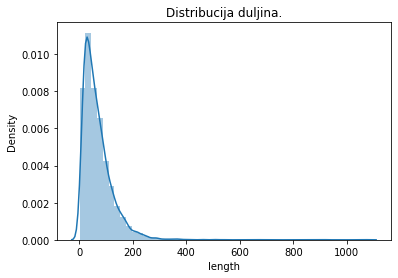

In [17]:
df=pd.DataFrame()
df["recenice"]=sen
df["length"] = df["recenice"].apply(len)
sns.distplot(df["length"]).set_title("Distribucija duljina.")

In [18]:
def var_row(row): #funkcija koja vraća varijancu ukupnog broja riječi 
    l = []
    for i in row:
        l.append(len(i.split()))
    return np.var(l)

**Graf koji prikazuje varijance duljina riječi.**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Varijance duljina riječi')

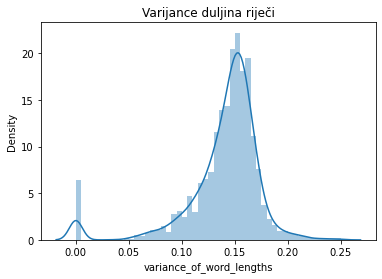

In [19]:
df["variance_of_word_lengths"] = df["recenice"].apply(lambda x: var_row(x))
sns.distplot(df["variance_of_word_lengths"]).set_title("Varijance duljina riječi")

In [20]:
print(f"Varijanca duljine rečenica: {round(np.var(df.length),4)}")

Varijanca duljine rečenica: 3270.6242


In [21]:
print(f"Standardna devijacija duljine rečenica: {round(math.sqrt(np.var(df.length)),4)}")

Standardna devijacija duljine rečenica: 57.1894


In [22]:
print(f"Srednja vrijednost broja slova po rečenici: {round(df.length.mean(),4)}")

Srednja vrijednost broja slova po rečenici: 67.6246


**Najfrekventnije riječi** 

Sada ćemo pronaći riječi s najvećim brojem pojavljivanja, te dobivene podatke prikazati grafički. 

In [23]:
from collections import Counter
dicti1 = Counter()
for word in uni:
      dicti1.update({word})

dicti1.most_common(10)

[(('<sent>',), 6518),
 (('</sent>',), 6518),
 (('the',), 3323),
 (('to',), 1844),
 (('and',), 1819),
 (('a',), 1578),
 (('of',), 1240),
 (('Harry',), 1222),
 (('was',), 1179),
 (('he',), 1034)]

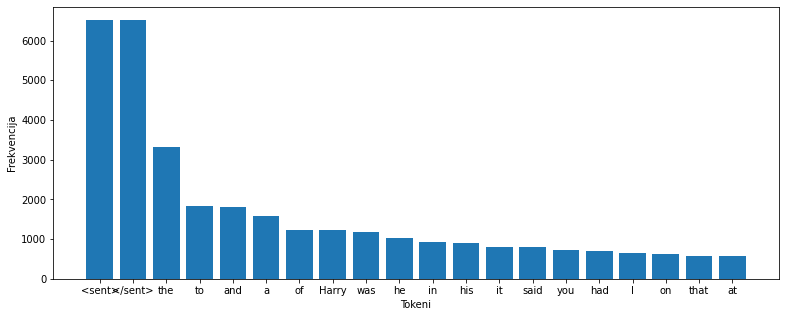

In [24]:
xs=[x[0] for x, y in dicti1.most_common(20)]
ys=[y for x, y in dicti1.most_common(20)]


plt.subplots(figsize=(13,5))
plt.bar(x=xs, height=ys)
plt.xlabel("Tokeni")
plt.ylabel("Frekvencija")
plt.show()

**Najfrekventniji bigrami** 

Sada ćemo pronaći bigrame s najvećim brojem pojavljivanja te dobivene podatke prikazati grafički. 

In [25]:
from collections import Counter
dicti2 = Counter()
for word in bi:
      dicti2.update({word})

dicti2.most_common(10)

[(('<sent>', 'He'), 482),
 (('<sent>', 'Harry'), 446),
 (('of', 'the'), 284),
 (('<sent>', 'The'), 275),
 (('in', 'the'), 262),
 (('<sent>', 'I'), 244),
 (('<sent>', 'It'), 211),
 (('on', 'the'), 207),
 (('to', 'the'), 170),
 (('<sent>', 'They'), 160)]

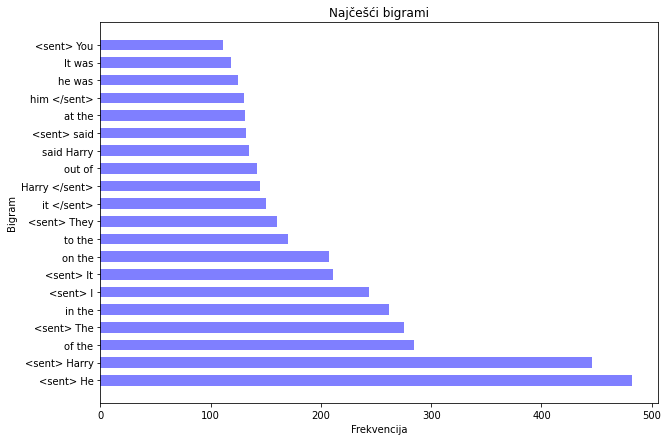

In [26]:
xs=[x[0]+" "+x[1] for x, y in dicti2.most_common(20)]
ys=[y for x, y in dicti2.most_common(20)]


plt.subplots(figsize=(10, 7)) 
plt.barh(y=xs, width=ys, height=0.6, alpha = 0.5, color="blue")

plt.xlabel('Frekvencija')
plt.ylabel('Bigram')
plt.title('Najčešći bigrami')

plt.show()

In [27]:
xs=[x[0]+" "+x[1] for x, y in dicti2.most_common()]
ys=[y for x, y in dicti2.most_common()]

fig = px.scatter(x=xs, y=ys, labels={"x":"Bigram", "y": "Frekvencija"})
fig.show()

**Najfrekventniji trigrami** 

Sada ćemo pronaći trigrame s najvećim brojem pojavljivanja te dobivene podatke prikazati grafički. 

In [28]:
from collections import Counter
dicti3 = Counter()
for word in tri:
      dicti3.update({word})

dicti3.most_common(10)

[(('<sent>', 'It', 'was'), 114),
 (('<sent>', 'He', 'was'), 69),
 (('out', 'of', 'the'), 61),
 (('said', 'Harry', '</sent>'), 57),
 (('said', 'Ron', '</sent>'), 53),
 (('<sent>', 'He', 'had'), 42),
 (('<sent>', 'There', 'was'), 40),
 (('Harry', 'and', 'Ron'), 36),
 (('<sent>', 'said', 'Harry'), 34),
 (('Ron', 'and', 'Hermione'), 33)]

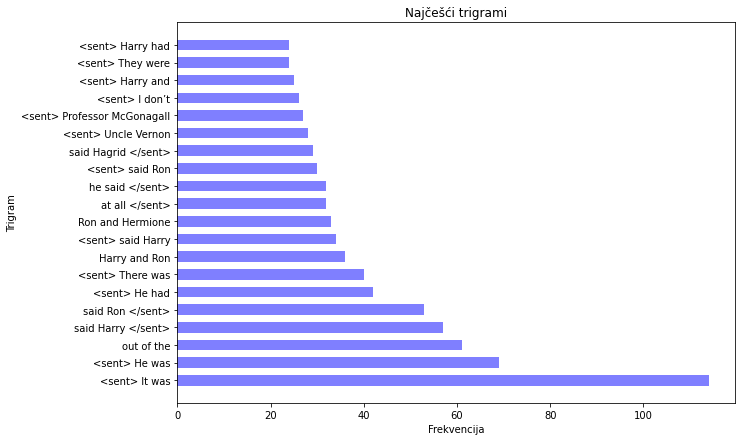

In [29]:
xs=[x[0]+" "+x[1]+" "+x[2] for x, y in dicti3.most_common(20)]
ys=[y for x, y in dicti3.most_common(20)]


plt.subplots(figsize=(10, 7)) 
plt.barh(y=xs, width=ys, height=0.6, alpha = 0.5, color="blue")

plt.xlabel('Frekvencija')
plt.ylabel('Trigram')
plt.title('Najčešći trigrami')

plt.show()

##Raspodjela korpusa i vjerojatnosti

Korpus smo  podijelile na tri dijela: trening podaci , razvojni podaci i testni podaci (u omjeru 70:15:15).


In [30]:
from sklearn.model_selection import train_test_split

train_X, temp=train_test_split(sen,train_size=0.7)
valid_X, test_X = train_test_split(temp, train_size=0.5)

Uzimamo unigrame, bigrame i trigrame iz dijela za trening.

In [31]:
uni_train=build_sent_ngram(train_X, 1)
bi_train=build_sent_ngram(train_X, 2)
tri_train=build_sent_ngram(train_X, 3)

Definiramo funkciju *makni_stop* koja za parametre prima *n* i *i*, gdje *n* označava radi li se o unigramu, bigramu ili trigramu, a *i* označava koji skup od navedenih u funkciji želimo koristiti. Ova funkcija je napravljena u svrhu uklanjanja stop-riječi iz skupova za treniranje, validaciju i testiranje.

In [33]:
def makni_stop(n,i):
  counter_words = Counter()
  n_st=[]
  skup1=[uni_train_bzs,vX1_bzs,uni_t_bzs]
  skup2=[bi_train_bzs,vX2_bzs,bi_t_bzs]
  skup3=[tri_train_bzs,vX3_bzs,tri_t_bzs]
  if n==1:
    for word in skup1[i]:
      if (word[0].lower() not in stop_words and word[0].isalnum()):
        counter_words.update((word[0]),)
        n_st.append((word[0],))
  elif n==2:
    br=0
    for word in skup2[i]:
        if (word[0].lower() not in stop_words and word[0].isalnum()) and (word[1].lower() not in stop_words and word[1].isalnum()):
            counter_words.update((word[0],word[1]))
            n_st.append((word[0],word[1]))
        else:
            skup2[i].pop(br)
        br+=1
  else:
    br=0
    for word in skup3[i]:
        if (word[0].lower() not in stop_words and word[0].isalnum()) and (word[1].lower() not in stop_words and word[1].isalnum()) and  (word[2].lower() not in stop_words and word[2].isalnum()) :
            counter_words.update((word[0],word[1],word[2]))
            n_st.append((word[0],word[1],word[2]))
        else:
            skup3[i].pop(br)
        br+=1
  return n_st

Gradimo i unigrame/bigrame/trigrame bez stop-riječi.

In [32]:
uni_train_bzs=build_sent_ngram(train_X, 1)
bi_train_bzs=build_sent_ngram(train_X, 2)
tri_train_bzs=build_sent_ngram(train_X, 3)

In [34]:
uni_train_bzs=makni_stop(1,0)
bi_train_bzs=makni_stop(2,0)
tri_train_bzs=makni_stop(3,0)

In [35]:
words_train=segment_word1(train_X) #pomoćna varijabla

Za svaku riječ iz rječnika određujemo frekvenciju pojavljivanja kako bismo mogli računati pripadne vjerojatnosti pojavljivanja. Definiramo pomoćnu funkciju *count*.

In [36]:
def count(sk):
  dicti_tr = Counter()
  for w in sk:
      dicti_tr.update({w})
  return dicti_tr

Definiramo funkciju *prob* koja prima parametre *sk* (skup unigrama, bigrama ili trigrama) ,*n* (uni,bi,tri) i *b* (pomoćni skup za računanje vjerojatnosti) koja računa vjerojatnost unigrama, bigrama i trigrama u skupu za trening.<br><br>
Ovo računamo po formulama $$P(w)=\frac{c(w)}{c(trening)}$$ za unigram, $$P(w_i | w_{i-1})=\frac{c(w_{i-1} w_i)}{c(w_{i-1})}$$ za bigram i $$P(w_i | w_{i-2}w_{i-1})=\frac{c(w_{i-2} w_{i-1} w_i)}{c(w_{i-2} w_{i-1})}$$ za trigram.

In [37]:
def prob(sk,n,b):
  #n = 1,2,3  (unigrami, bigrami, trigrami)
  dicti_tr=count(sk)

  prob={}

  if(n==1):
    for k in dicti_tr:
      if k not in prob:
        prob[k]=dicti_tr[k]/len(words_train)

  elif (n==2):
    a=count(b)
    for k in sk:
      if k not in prob:
        if a[(k[0],)]!=0:
          prob[k]=dicti_tr[k]/a[(k[0],)]
        else:
          prob[k]=0
  else:
    a=count(b)
    for k in sk:
      if k not in prob:
        if a[(k[0],k[1])]!=0:
          prob[k]=dicti_tr[k]/a[(k[0],k[1])]
        else:
          prob[k]=0



  return prob

  


Računamo vjerojatnosti svih dosad definiranih n-grama.

In [38]:
prob_uni=prob(uni_train,1,0)

In [39]:
prob_bi=prob(bi_train,2,uni_train)


In [40]:
prob_tri=prob(tri_train,3,bi_train)

In [41]:
prob_uni_bzs=prob(uni_train_bzs,1,0)
prob_bi_bzs=prob(bi_train_bzs,2,uni_train_bzs)
prob_tri_bzs=prob(tri_train_bzs,3,bi_train_bzs)

Npr. vjerojatnost pojavljivanja unigrama "fast" u korpusu za trening je 0,2411%.

In [101]:
prob_uni[('fast',)]

0.0024112231477422183

##Izgradnja modela

In [42]:
dicti1_tr=count(uni_train) #pomoćna varijabla - broj unigrama u korpusu za trening

Naš projekt će konstruirati interpolacijski jezični model. <br><br>
Interpolacijski model koristi formulu <br><br>
$$P(w_n | w_{n-2} w_{n-1}) = λ_3P(w_n | w_{n-2} w_{n-1}) + λ_2P(w_n | w_{n-1}) + λ_1P(w_n) + \frac{λ_0}{|V|}$$<br>
tako da vrijedi $∑_iλ_i=1$ (i V je riječnik). <br><br>
Vrijednosti $\lambda_i$ su uvjetovane sadržajem.

Za traženje $λ_i$ koristimo razvojni skup podataka i namještamo vrijednosti na korpusu za trening.<br><br>
Postupak traženja λ:<br>
1. **računamo vjerojatnosti za validacijski skup**
2. **računamo $c(λ_i)$** (formula dalje u projektu)
3. **normaliziramo $λ_i$**
4. **postupak ponavljamo dok razlika $λ^{(i)}$ i $λ^{(i-1)}$ manja od $0.01$**

In [43]:
y0=0.25
y1=0.25
y2=0.25
y3=0.25

Gradimo unigrame (*vX1*), bigrame (*vX2*) i trigrame (*vX3*) za validacijski skup (dodatno gradimo i verzije bez stop riječi - dodajemo "*_bzs*" nazivima varijabli).

In [44]:
vX1=build_sent_ngram(valid_X, 1)
vX2=build_sent_ngram(valid_X, 2)
vX3=build_sent_ngram(valid_X, 3)

In [45]:
vX1_bzs=build_sent_ngram(valid_X, 1)
vX2_bzs=build_sent_ngram(valid_X, 2)
vX3_bzs=build_sent_ngram(valid_X, 3)

In [46]:
vX1_bzs=makni_stop(1,1)
vX2_bzs=makni_stop(2,1)
vX3_bzs=makni_stop(3,1)

Definirajmo funkciju *pomocna_validacija* koja će računati vjerojatnosti unigrama/bigrama/trigrama za validacijski skup. To računamo po formuli <br><br>
$$p_v(w_n | h_i) = λ_3p(w_n | w_{n-2} w_{n-1}) + λ_2p(w_n | w_{n-1}) + λ_1p(w_n) + \frac{λ_0}{|V|}$$<br>
$p$ su vjerojatnosti skupa za trening.<br>
Funckija prima unigrame (*u*), bigrame (*b*) i tragrame (*t*). Parametar i je pmoćni parametar koji nam govori s kojim validacijskim skupom baratamo ( (ne)normaliziran, sa/bez stop riječi), *n* nam govori koliko λ nam  (uni/bi/tri), a *c* su spremljene λ.

In [47]:
def pomocna_validacija(u,b,t,i,n,c):
  prob_val={}

  #brojimo uni/bi/tri
  dicti_val1 = count(u)
  dicti_val2 = count(b)
  dicti_val3 = count(t)
  
  #(ne)normalizirano, sa/bez stopwords
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs] #uni
  skup2=[prob_bi,prob_bi_n,prob_bi_n_bzs,prob_bi_bzs] #bi
  skup3=[prob_tri,prob_tri_n,prob_tri_n_bzs,prob_tri_bzs] #tri


  for k in dicti_val1:
    if k in skup1[i].keys(): 
      prob_val[k]=(c[0]/len(dicti1_tr))+(c[1]*skup1[i][k])
    else:
      prob_val[k]=(c[0]/len(dicti1_tr))
  
  if(n==2 or n==3):
    for k in dicti_val2:
      if k in skup2[i].keys() and (k[0],) in skup1[i].keys():
        prob_val[k]=(c[0]/len(dicti1_tr)) +c[1]*skup1[i][(k[0],)] + c[2]*skup2[i][k]
      elif k in skup2[i].keys() and (k[0],) not in skup1[i].keys():
        prob_val[k]=(c[0]/len(dicti1_tr)) +c[1]*skup1[i][(k[0],)]
  
  if(n==3): 
    for k in dicti_val3:
      if k in skup3[i].keys() and (k[0],k[1]) in skup2[i].keys() and (k[0],) in skup1[i].keys():
        prob_val[k]=(c[0]/len(dicti1_tr)) +c[1]*skup1[i][(k[0],)] + c[2]*skup2[i][(k[0],k[1])] + c[3]*skup3[i][k]
      elif k not in skup3[i].keys() and (k[0],k[1]) in skup2[i].keys() and (k[0],) in skup1[i].keys():
        prob_val[k]=(c[0]/len(dicti1_tr)) +c[1]*skup1[i][(k[0],)] + c[2]*skup2[i][(k[0],k[1])]
      else:
        if (k[0],) in skup1[i].keys():
          prob_val[k]=(c[0]/len(dicti1_tr)) +c[1]*skup1[i][(k[0],)]
        else:
           prob_val[k]=(c[0]/len(dicti1_tr))


  return prob_val



S pomoćnom funkcijom *suma_c* računamo <br><br>
$$c(λ_j)=\sum_{i=0}^{|H|}\frac{λ_jp_j(w_i | h_i)}{p_v(w_i | h_i)}$$<br>
za svaki λ.<br>
Funkcija prima je li riječ o uni/bi/tri, $λ_j$, izračunate vjerojatnosti validacijskog skupa, vjerojatnost uni/bi/tri i broj jedinstvenih riječi u skupu za trening.

In [102]:
def suma_c(n,c,val,prob_n,velicina):

  
  suma=0
  if n==0:
    for k in val.keys(): 
        if(val[k]!=0):
          suma+=(1/val[k])
        else:
          suma+=0
    c=c*(1/(velicina))*suma


  elif n==1:
    for k in val.keys(): 
      if k in prob_n.keys():
        suma+=(prob_n[k]/val[k])
      else:
        suma+=0
    c=c*suma


  elif n==3:
    for k in val.keys(): 
      if k in prob_n.keys():
        suma+=(prob_n[k]/val[k])
      else:
        suma+=0
    c=c*suma

  else:
    for k in val.keys(): 
      if k in prob_n.keys():
        suma+=(prob_n[k]/val[k])
      else:
        suma+=0
    c=c*suma

  
  
  return c




Definiramo funkcije *nadi_y3*, *nadi_y2* i *nadi_y1* s kojima provodimo postupak traženja λ ovisno o tome koliko nam λ treba tj. za koji model tražimo (uni/bi/tri).<br>
*i* nam govori s kojim skupom baratamo.
<br><br>
Početne $λ_i$ postavimo na $\frac{1}{brλ}$. <br>
Normaliziramo s 
$$λ_{j(norm)}=c(\lambda_{j(nenorm)})\div\sum_{k}{c(λ_k)}$$

In [103]:
def nadi_y3(i):

  vl={}
  c={0:0.25,1:0.25,2:0.25,3:0.25}
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]
  skup2=[prob_bi,prob_bi_n,prob_bi_n_bzs,prob_bi_bzs,prob_t_2,prob_t_2_bzs,prob_nt_2,prob_nt_2_bzs]
  skup3=[prob_tri,prob_tri_n,prob_tri_n_bzs,prob_tri_bzs,prob_t_3,prob_t_3_bzs,prob_nt_3,prob_nt_3_bzs]


  if(i==0 or i==3): #gledamo koji validacijski skup uzimamo
    if(i==0):
      vl=pomocna_validacija(vX1,vX2,vX3,0,3,c.copy())
    else:
      vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,3,c.copy())

  else:
    if(i==1):
      vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,3,c.copy())

    else:
      vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,3,c.copy())

  
  dicti1_tr=count(skup1[i])

  c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

  c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))

  c[2]=suma_c(2,c[2],vl,skup2[i],len(skup1[i]))

  c[3]=suma_c(3,c[3],vl,skup3[i],len(skup1[i]))
  
  
  temp_c=c.copy()
  for c_y in temp_c.keys():
    c[c_y]=temp_c[c_y]/sum(temp_c.values()) #normaliziramo

  y0,y1,y2,y3=c[0],c[1],c[2],c[3]


  
  while abs(y0-c[0])>=0.01 or abs(y1-c[1])>=0.01 or abs(y2-c[2])>=0.01 or abs(y3-c[3])>=0.01: #ponavljamo dok razlika trenutnog i prethodnog >=0.01


    y0,y1,y2,y3=c[0],c[1],c[2],c[3]

    if(i==0 or i==3):
      if(i==0):
        vl=pomocna_validacija(vX1,vX2,vX3,0,3,c.copy())
      else:
        vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,3,c.copy())

    else:
      if(i==1):
        vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,3,c.copy())

      else:
        vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,3,c.copy())

    c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

    c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))

    c[2]=suma_c(2,c[2],vl,skup2[i],len(skup1[i]))

    c[3]=suma_c(3,c[3],vl,skup3[i],len(skup1[i]))

    temp_c=c.copy()
    for c_y in temp_c.keys():
      c[c_y]=temp_c[c_y]/sum(temp_c.values())


  
  return c


In [105]:
def nadi_y2(i):

  vl={}
  c={0:0.3333,1:0.3333,2:(1-0.3333*2)}
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]
  skup2=[prob_bi,prob_bi_n,prob_bi_n_bzs,prob_bi_bzs,prob_t_2,prob_t_2_bzs,prob_nt_2,prob_nt_2_bzs]

  
  if(i==0 or i==3):
    if(i==0):
      vl=pomocna_validacija(vX1,vX2,vX3,0,2,c.copy())
    else:
      vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,2,c.copy())

  else:
    if(i==1):
      vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,2,c.copy())

    else:
      vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,2,c.copy())

  
  dicti1_tr=count(skup1[i])

  c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

  c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))

  c[2]=suma_c(2,c[2],vl,skup2[i],len(skup1[i]))

  
  
  temp_c=c.copy()
  for c_y in temp_c.keys():
    c[c_y]=temp_c[c_y]/sum(temp_c.values())

  y0,y1,y2=c[0],c[1],c[2]


  
  while abs(y0-c[0])>=0.01 or abs(y1-c[1])>=0.01 or abs(y2-c[2])>=0.01:


    y0,y1,y2=c[0],c[1],c[2]

    if(i==0 or i==3):
      if(i==0):
        vl=pomocna_validacija(vX1,vX2,vX3,0,3,c.copy())
      else:
        vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,3,c.copy())

    else:
      if(i==1):
        vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,2,c.copy())

      else:
        vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,2,c.copy())

    c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

    c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))

    c[2]=suma_c(2,c[2],vl,skup2[i],len(skup1[i]))



    temp_c=c.copy()
    for c_y in temp_c.keys():
      c[c_y]=temp_c[c_y]/sum(temp_c.values())


  
  return c


In [107]:
def nadi_y1(i):

  vl={}
  c={0:0.5,1:0.5}
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]

  
  if(i==0 or i==3):
    if(i==0):
      vl=pomocna_validacija(vX1,vX2,vX3,0,1,c.copy())
    else:
      vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,1,c.copy())

  else:
    if(i==1):
      vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,1,c.copy())

    else:
      vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,1,c.copy())

  
  dicti1_tr=count(skup1[i])

  c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

  c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))


  
  
  temp_c=c.copy()
  for c_y in temp_c.keys():
    c[c_y]=temp_c[c_y]/sum(temp_c.values())

  y0,y1=c[0],c[1]


  
  while abs(y0-c[0])>=0.01 or abs(y1-c[1])>=0.01:


    y0,y1=c[0],c[1]

    if(i==0 or i==3):
      if(i==0):
        vl=pomocna_validacija(vX1,vX2,vX3,0,3,c.copy())
      else:
        vl=pomocna_validacija(vX1_bzs,vX2_bzs,vX3_bzs,3,1,c.copy())

    else:
      if(i==1):
        vl=pomocna_validacija(sa_stop1v,sa_stop2v,sa_stop3v,1,1,c.copy())

      else:
        vl=pomocna_validacija(bez_stop1v,bez_stop2v,bez_stop3v,2,1,c.copy())

    c[0]=suma_c(0,c[0],vl,skup1[i],len(skup1[i]))

    c[1]=suma_c(1,c[1],vl,skup1[i],len(skup1[i]))




    temp_c=c.copy()
    for c_y in temp_c.keys():
      c[c_y]=temp_c[c_y]/sum(temp_c.values())


  
  return c


##Računanje vjerojatnosti uni/bi/tri i rečenice

Spremimo naše λ u odgovarajuće skupove ovisno o modelu (uni, bi, tri) i mičemo li stopwords.

In [58]:
c3=nadi_y3(0)
c2=nadi_y2(0)
c1=nadi_y1(0)
cbs1=nadi_y3(3)
cbs2=nadi_y3(3)
cbs3=nadi_y3(3)

Definirajmo *vjer_tri*, *vjer_bi* i *vjer_tri* koje račinaju vjerojatnost danih trigrama, bigrama, uniigrama.<br>
Funkcije primaju i pomoćni *i* koji nam govori s kojim skupom baratamo i *c* koji sadrži.<br>
Vjerojatnosti računamo po prije spomenutom modelu interpolacije<br><br>
$$P(w_n | w_{n-2} w_{n-1}) = λ_3P(w_n | w_{n-2} w_{n-1}) + λ_2P(w_n | w_{n-1}) + λ_1P(w_n) + \frac{λ_0}{|V|}$$<br><br>
U slučaju da ne postoji dani n-gram u skupu za trening, njegovu vjerojatnost smatramo da je 0.

In [59]:
def vjer_tri(r1,r2,r3,i,c):
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]
  skup2=[prob_bi,prob_bi_n,prob_bi_n_bzs,prob_bi_bzs,prob_t_2,prob_t_2_bzs,prob_nt_2,prob_nt_2_bzs]
  skup3=[prob_tri,prob_tri_n,prob_tri_n_bzs,prob_tri_bzs,prob_t_3,prob_t_3_bzs,prob_nt_3,prob_nt_3_bzs]

  y0,y1,y2,y3=c[0],c[1],c[2],c[3]
  if (r1,r2,r3) in skup3[i].keys() and (r1,r2) in skup2[i].keys() and (r1,) in skup1[i].keys():
    vj=y3*skup3[i][(r1,r2,r3)]+y2*skup2[i][(r1,r2)]+y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  elif (r1,r2,r3) not in skup3[i].keys() and (r1,r2) in skup2[i].keys() and (r1,) in skup1[i].keys(): 
    vj=y2*skup2[i][(r1,r2)]+y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  elif (r1,r2,r3) not in skup3[i].keys() and (r1,r2) not in skup2[i].keys() and (r1,) in skup1[i].keys():
    vj=y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  else:
    vj=y0/len(dicti1_tr)

  return vj

In [60]:
def vjer_bi(r1,r2,i,c):
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]
  skup2=[prob_bi,prob_bi_n,prob_bi_n_bzs,prob_bi_bzs,prob_t_2,prob_t_2_bzs,prob_nt_2,prob_nt_2_bzs]
  
  y0,y1,y2=c[0],c[1],c[2]
  if (r1,r2) in skup2[i].keys() and (r1,) in skup1[i].keys():
    vj=y2*skup2[i][(r1,r2)]+y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  elif (r1,r2) not in skup2[i].keys() and (r1,) in skup1[i].keys():
    vj=y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  else:
    vj=y0/len(dicti1_tr)

  return vj

In [61]:
def vjer_uni(r1,i,c):
  skup1=[prob_uni,prob_uni_n,prob_uni_n_bzs,prob_uni_bzs,prob_t_1,prob_t_1_bzs,prob_nt_1,prob_nt_1_bzs]
  
  y0,y1=c[0],c[1]
  if (r1,) in skup1[i].keys():
    vj=y1*skup1[i][(r1,)]+y0/len(dicti1_tr)
  else:
    vj=y0/len(dicti1_tr)

  return vj

Definirajmo i funkcije za računanje vjerojatnosti dane rečenice ovisno o modelu (uni/bi/tri).<br>
Funkcije primaju rečenicu, pomoćni *i* koji nam govori s kakvim skupom radimo i bool *s* koji nam govori radimo li sa stopwords ili ne. Ako ne, sa pomoćnom funkcijom *stop* mičemo stopwords.

In [62]:
def vjerojatnost_recenice3(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cbs3
    else:
      rijeci = recenica.split(" ")
      v=c3
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],3)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_tri(t[0],t[1],t[2],i,v)
    return vjerojatnost    

In [63]:
def vjerojatnost_recenice2(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cbs2
    else:
      rijeci = recenica.split(" ")
      v=c2
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],2)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_bi(t[0],t[1],i,v)
    return vjerojatnost  

In [64]:
def vjerojatnost_recenice1(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cbs1
    else:
      rijeci = recenica.split(" ")
      v=c1
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],1)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_uni(t[0],i,v)
    return vjerojatnost  

##Normalizirani model

Građenje normaliziranog modela je analogno gradnji modela koji nije normaliziran.
<br><br>Za početak ponovno učitavamo korpus, dijelimo ga u rečenice, te dijelimo dobiveni skup rečenica u skupove za trening, validaciju i testiranje u omjeru 70:15:15. Potom gradimo skupove unigrama, bigrama i trigrama za trening i validacijske skupove, kao što smo radili i u prethodnom dijelu.

In [65]:
normal_sen=split_into_sentences(k1)

In [66]:
train_X, temp=train_test_split(normal_sen,train_size=0.7)
valid_X, test_X = train_test_split(temp, train_size=0.5)

In [67]:
uni_n=build_sent_ngram(train_X, 1)
bi_n=build_sent_ngram(train_X, 2)
tri_n=build_sent_ngram(train_X, 3)

uni_n_v=build_sent_ngram(valid_X, 1)
bi_n_v=build_sent_ngram(valid_X, 2)
tri_n_v=build_sent_ngram(valid_X, 3)

Definiramo funkciju *norm_count* koja prima parametre *n,st* i *i*, gdje *n* označava radi li se o unigramu, bigramu ili trigramu, *st* označava želimo li izbaciti stop-riječi ili ne, a *i* nam govori koji skup ćemo koristiti za izgradnju n-grama.

In [68]:
def norm_count(n,st,i):
  skup1=[uni_n,uni_n_v,sa_stop1_t]
  skup2=[bi_n,bi_n_v,sa_stop2_t]
  skup3=[tri_n,tri_n_v,sa_stop3_t]
  counter_words = Counter()
  n_stem=[]

  if st==True: #bez stopwords
    if n==1:
      for word in skup1[i]:
        if (word[0].lower() not in stop_words and word[0].isalnum()):
          counter_words.update({(stemmer(word[0]),)})
          n_stem.append((stemmer(word[0]),)) #dodajemo stemmiran unigram
    elif n==2:
      br=0
      for word in skup2[i]:
          if (word[0].lower() not in stop_words and word[0].isalnum()) and (word[1].lower() not in stop_words and word[1].isalnum()):
              counter_words.update({(stemmer(word[0]),stemmer(word[1]))})
              n_stem.append((stemmer(word[0]),stemmer(word[1]))) #stemmiran bigram
          else:
              skup2[i].pop(br)
          br+=1
    else:
      br=0
      for word in skup3[i]:
          if (word[0].lower() not in stop_words and word[0].isalnum()) and (word[1].lower() not in stop_words and word[1].isalnum()) and  (word[2].lower() not in stop_words and word[2].isalnum()) :
              counter_words.update({(stemmer(word[0]),stemmer(word[1]),stemmer(word[2]))})
              n_stem.append((stemmer(word[0]),stemmer(word[1]),stemmer(word[2]))) #stemmiran trigram
          else:
              skup3[i].pop(br)
          br+=1
  else: #sa stopwords
    if n==1:
      for word in skup1[i]:
        if (word[0].isalnum()):
          counter_words.update({(stemmer(word[0]),)})
          n_stem.append((stemmer(word[0]),))
          
    elif n==2:
      br=0
      for word in skup2[i]:
          if (word[0].isalnum()) and (word[1].isalnum()):
              counter_words.update({(stemmer(word[0]),stemmer(word[1]))})
              n_stem.append((stemmer(word[0]),stemmer(word[1])))
          else:
              skup2[i].pop(br)
          br+=1
    else:
      br=0
      for word in skup3[i]:
          if (word[0].isalnum()) and (word[1].isalnum()) and  word[2].isalnum() :
              counter_words.update({(stemmer(word[0]),stemmer(word[1]))})
              n_stem.append((stemmer(word[0]),stemmer(word[1]),stemmer(word[2])))
          else:
              skup3[i].pop(br)
          br+=1
  return n_stem




Gradimo normalizirane(stemmirane) unigrame, bigrame i trigrame sa/bez stopwords.

In [69]:
sa_stop1=norm_count(1,False,0)
sa_stop2=norm_count(2,False,0)
sa_stop3=norm_count(3,False,0)
bez_stop1=norm_count(1,True,0)
bez_stop2=norm_count(2,True,0)
bez_stop3=norm_count(3,True,0)

Zatim računamo vjerojatnosti tih n-grama.

In [70]:
prob_uni_n=prob(sa_stop1,1,0)
prob_bi_n=prob(sa_stop2,2,sa_stop1)
prob_tri_n=prob(sa_stop3,3,sa_stop2)

In [71]:
prob_uni_n_bzs=prob(bez_stop1,1,0)
prob_bi_n_bzs=prob(bez_stop2,2,bez_stop1)
prob_tri_n_bzs=prob(bez_stop3,3,bez_stop2)

Također pravimo normalizirane n-grame validacijskog skupa sa i bez stop-riječi. 

In [72]:
sa_stop1v=norm_count(1,False,1)
sa_stop2v=norm_count(2,False,1)
sa_stop3v=norm_count(3,False,1)
bez_stop1v=norm_count(1,True,1)
bez_stop2v=norm_count(2,True,1)
bez_stop3v=norm_count(3,True,1)

Sada tražimo λ kao i u prethodnom dijelu, samo za normalizirane skupove.
Opet gledamo radi li se o modelu unigrama, bigrama ili trigrama, pa ćemo ovisno o tome kao povratnu informaciju imati listu sastavljenu od 2, 3 ili 4 λ.



In [75]:
cn3=nadi_y3(1)
cn2=nadi_y2(1)
cn1=nadi_y1(1)
cnbs1=nadi_y3(2)
cnbs2=nadi_y3(2)
cnbs3=nadi_y3(2)

Ovdje smo definirali pomoćnu funkciju koja izbacuje stop-riječi iz dane rečenice, a vraća list riječi koje nisu stopwords.

In [76]:
def stop(rec):
  rijeci = rec.split(" ")
  novo=[]
  for word in rijeci:
      if (word.lower() not in stop_words and word.isalnum()):
        novo.append(word)
  return novo



Sada smo definirali funkcije za računanje vjerojatnosti rečenica koje su normalizirane, odnosno čije su riječi korijenovane. Funkcije kao parametar primaju, osim rečenice, još i parametar *s* koji označava želimo li izbaciti stop-riječi. Također primaju i parametar *i* koji nam govori s kojim skupom baratamo.

In [77]:
dicti1_tr=count(uni_n) #pomoćna varijabla koja broji normalizirane unigrame

In [78]:
def vjerojatnost_recenice3_norm(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cnbs3
    else:
      rijeci = recenica.split(" ")
      v=cn3
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],3)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_tri(stemmer(t[0]),stemmer(t[1]),stemmer(t[2]),i,v)
    return vjerojatnost    

In [79]:
def vjerojatnost_recenice2_norm(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cnbs2
    else:
      rijeci = recenica.split(" ")
      v=cn2
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],2)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_bi(stemmer(t[0]),stemmer(t[1]),i,v)
    return vjerojatnost  

In [80]:
def vjerojatnost_recenice1_norm(recenica,s,i):
    vjerojatnost = 1
    if s==True:
      rijeci=stop(recenica)
      v=cnbs1
    else:
      rijeci = recenica.split(" ")
      v=cn1
    duljina = len(rijeci)
    tri=build_sent_ngram([recenica],1)
    for t in tri:
          vjerojatnost = vjerojatnost*vjer_uni(stemmer(t[0]),i,v)
    return vjerojatnost  

##Perpleksija

In [81]:
import math

Testirajmo naš model.<br><br>
Izgradimo skupove unigrama, bigrama, tri grama za sve kombinacije sa/bez normalizacije i sa/bez stop-riječi.

In [82]:
#bez normalizacije i sa stopwords
words_train=segment_word1(test_X)
uni_t=build_sent_ngram(test_X, 1)
bi_t=build_sent_ngram(test_X, 2)
tri_t=build_sent_ngram(test_X, 3)

In [83]:
uni_t_bzs=build_sent_ngram(test_X, 1)
bi_t_bzs=build_sent_ngram(test_X, 2)
tri_t_bzs=build_sent_ngram(test_X, 3)

In [84]:
#bez normalizacije i bez stopwords
uni_t_bzs=makni_stop(1,2)
bi_t_bzs=makni_stop(2,2)
tri_t_bzs=makni_stop(3,2)

In [85]:
sa_stop1_t=build_sent_ngram(test_X, 1)
sa_stop2_t=build_sent_ngram(test_X, 2)
sa_stop3_t=build_sent_ngram(test_X, 3)

In [86]:
#normalizirano sa/bez stopwords
sa_stop1_t=norm_count(1,False,2)
sa_stop2_t=norm_count(2,False,2)
sa_stop3_t=norm_count(3,False,2)
bez_stop1_t=norm_count(1,True,2)
bez_stop2_t=norm_count(2,True,2)
bez_stop3_t=norm_count(3,True,2)

Izračunajmo im i sve vjerojatnosti.

In [87]:
prob_t_1=prob(uni_t,1,0)
prob_t_2=prob(bi_t,2,uni_t)
prob_t_3=prob(tri_t,3,bi_t)
prob_t_1_bzs=prob(uni_t_bzs,1,0)
prob_t_2_bzs=prob(bi_t_bzs,2,uni_t_bzs)
prob_t_3_bzs=prob(tri_t_bzs,3,bi_t_bzs)
prob_nt_1=prob(sa_stop1_t,1,0)
prob_nt_2=prob(sa_stop2_t,2,sa_stop1_t)
prob_nt_3=prob(sa_stop3_t,3,sa_stop2_t)
prob_nt_1_bzs=prob(bez_stop1_t,1,0)
prob_nt_2_bzs=prob(bez_stop2_t,2,bez_stop1_t)
prob_nt_3_bzs=prob(bez_stop3_t,3,bez_stop2_t)

Provjeravamo kvalitetu modela računanjem perpleksije. <br><br>
Za računanje perpleksije koristimo formulu<br><br>
$$PP_p(T)=2^{H_p(T)}$$<br>
gdje je $T$ testni skup, a $H_p$ unakrsna entropija tj. <br><br>
$$H_p(T)=-\frac{1}{|T|}\sum_{i=1}^{|T|}\log_{2}p(w_i)$$

###Računanje perpleksije bez normalizacije i bez uklanjanja stop-riječi

In [88]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice3(r,False,4)
  perpleksija+=math.log(a,2) #pozbrojimo logaritme
  
perpleksija*=-1/len(prob_t_3) #to pomnožimo sa -1/|T|
perpleksija = pow(2,perpleksija) #i dignemo na bazu 2
print(perpleksija)

5.700321437710047


In [89]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice2(r,False,4)
  perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_t_2)
perpleksija = pow(2,perpleksija)
print(perpleksija)

21.476351263370468


In [90]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice1(r,False,4)
  if(a>0):
    perpleksija+=math.log(a,2)

perpleksija*=-1/len(prob_t_1)
perpleksija = pow(2,perpleksija)

print(perpleksija)


581456976.5545844


Najbolji model dobivamo za najmanju perpleksiju tj. za tekst bez normalizacije sa stop-riječima najbolji model je model unigrama.

###Računanje perpleksije bez normalizacije i bez stop-riječi

In [91]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice3(r,True,5)
  if(a>0):
    perpleksija+=math.log(a,2)

perpleksija*=-1/len(prob_t_3_bzs)
perpleksija = pow(2,perpleksija)
print(perpleksija)


4.0139770818343275e+65


In [92]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice2(r,True,5)
  if(a>0):
    perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_t_2_bzs)
perpleksija = pow(2,perpleksija)
print(perpleksija)

1.164616197616402e+27


In [93]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice1(r,True,5)
  if(a>0):
    perpleksija+=math.log(a,2)

perpleksija*=-1/len(prob_t_1_bzs)
perpleksija = pow(2,perpleksija)

print(perpleksija)


5.93720877038202e+20


Za tekst bez normalizacije i bez stop-riječi najbolji model je model trigrama.

###Računanje perpleksije sa normalizacijom i bez uklanjanja stop-riječi

In [94]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice3_norm(r,False,6)
  if(a>0):
    perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_nt_3)
perpleksija = pow(2,perpleksija)
print(perpleksija)

197802.55026591572


In [95]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice2_norm(r,False,6)
  if(a>0):
    perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_nt_2)
perpleksija = pow(2,perpleksija)
print(perpleksija)

108025.82489519741


In [96]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice1_norm(r,False,6)
  if(a>0):
    perpleksija+=math.log(a,2)

perpleksija*=-1/len(prob_nt_1)
perpleksija = pow(2,perpleksija)

print(perpleksija)


8.214090960246675e+16


Za normalizirani tekst sa stop-riječima najbolji model je model bigrama.

###Računanje perpleksije sa normalizacijom i bez stop-riječi

In [97]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice3_norm(r,True,7)
  if(a>0):
   perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_nt_3_bzs)
perpleksija = pow(2,perpleksija)
print(perpleksija)

2.4563660304202553e+43


In [98]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice2_norm(r,True,7)
  if(a>0):
    perpleksija+=math.log(a,2)
  
perpleksija*=-1/len(prob_nt_2_bzs)
perpleksija = pow(2,perpleksija)
print(perpleksija)

1.792318676559668e+20


In [99]:
perpleksija=0
for r in test_X:
  a=vjerojatnost_recenice1_norm(r,True,7)
  if(a>0):
    perpleksija+=math.log(a,2)

perpleksija*=-1/len(prob_nt_1_bzs)
perpleksija = pow(2,perpleksija)

print(perpleksija)


1.6463735087975352e+26


Za normalizirani tekst bez stop-riječi najbolji model je model bigrama.